In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .getOrCreate()

print('pyspark ready ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [2]:
from mlonspark import AlternatingLeastSquare
def initalg(val):
    return AlternatingLeastSquare()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("scaled-by-artist")\
    .setRank(val)\
    .setImplicitPrefs(True)


In [3]:
train = spark.read.load("/data/lastfm-dataset-360K/coo-data-train.parquet")
test = spark.read.load("/data/lastfm-dataset-360K/coo-data-test.parquet")

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setLabelCol("scaled-by-artist")\
    .setPredictionCol("prediction")

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        res.append([i, trainRmse, testRmse])
    return res

In [5]:
import numpy as np
rng = np.arange(4, 50, 2).tolist()
res = runtest(rng)
print(res)

[[4, 1.8311732161912815, 1.8199915431250113], [6, 1.8242046413086885, 1.8138949944179834], [8, 1.8193700115588436, 1.8098943460819281], [10, 1.8151628362376524, 1.8064788591404661], [12, 1.8117039094785006, 1.8036965289020621], [14, 1.808662478189435, 1.801288313247504], [16, 1.8059492059143851, 1.799148336405782], [18, 1.8035630647445473, 1.7974907014581283], [20, 1.801180059371271, 1.7957262763913828], [22, 1.7990847392011684, 1.794112687483201], [24, 1.7971327716479502, 1.7927678335769068], [26, 1.7952815519608456, 1.7914249603717574], [28, 1.7936176371558588, 1.7903321675989865], [30, 1.7919446280636202, 1.7890888760858827], [32, 1.7903977155987005, 1.7880812615619677], [34, 1.788838276361532, 1.7869750946903213], [36, 1.78744969060367, 1.786140593226233], [38, 1.7860492767752296, 1.7852702530955766], [40, 1.7847804952669333, 1.7844925631240711], [42, 1.7834215201915897, 1.7836590693881051], [44, 1.7822520547157832, 1.782937490880227], [46, 1.7810415209530723, 1.7823152309550803], 

In [6]:
x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

print(yTest)

[1.8199915431250113, 1.8138949944179834, 1.8098943460819281, 1.8064788591404661, 1.8036965289020621, 1.801288313247504, 1.799148336405782, 1.7974907014581283, 1.7957262763913828, 1.794112687483201, 1.7927678335769068, 1.7914249603717574, 1.7903321675989865, 1.7890888760858827, 1.7880812615619677, 1.7869750946903213, 1.786140593226233, 1.7852702530955766, 1.7844925631240711, 1.7836590693881051, 1.782937490880227, 1.7823152309550803, 1.7816131156735835]


Text(0, 0.5, 'RMSE')

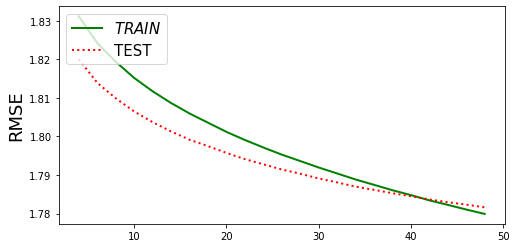

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)